<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/nlp/pytorch-seq2seq/6_Attention_is_All_You_Need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)

Reference: [Bentrevett](https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb)

In [68]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from tqdm import tqdm
from torch import nn
import torchtext
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import io

In [2]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

2023-08-30 18:52:10.341052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 18:52:11.273343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-30 18:52:12.782737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 18:52:12.783240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [3]:

url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def build_vocab(filepath, tokenizer):
    counter = Counter()
    with io.open(filepath, encoding="utf8") as f:
        for string_ in f:
            counter.update(tokenizer(string_))
    v2 = vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
    v2.set_default_index(0)
    return v2

de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

def data_process(filepaths):
    raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    data = []
    for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
        de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de)],
                                dtype=torch.long)
        en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)],
                                dtype=torch.long)
        data.append((de_tensor_, en_tensor_))
    return data

train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

100%|██████████| 637k/637k [00:00<00:00, 12.8MB/s]
100%|██████████| 569k/569k [00:00<00:00, 10.6MB/s]
100%|██████████| 24.7k/24.7k [00:00<00:00, 2.26MB/s]
100%|██████████| 21.6k/21.6k [00:00<00:00, 2.27MB/s]
100%|██████████| 22.9k/22.9k [00:00<00:00, 3.86MB/s]
100%|██████████| 21.1k/21.1k [00:00<00:00, 2.66MB/s]


In [4]:
BATCH_SIZE = 128
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def generate_batch(data_batch):
  de_batch, en_batch = [], []
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
  de_batch = pad_sequence(de_batch, padding_value=PAD_IDX,batch_first = True)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX,batch_first = True)
  return de_batch, en_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

In [5]:
x , y = next(iter(train_iter))
x.shape,y.shape

(torch.Size([128, 25]), torch.Size([128, 28]))

In [6]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self,hid_dim,n_heads,dropout):
        super(MultiHeadAttentionLayer,self).__init__()

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim,hid_dim)
        self.fc_k = nn.Linear(hid_dim,hid_dim)
        self.fc_v = nn.Linear(hid_dim,hid_dim)

        self.fc_o = nn.Linear(hid_dim,hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.tensor([self.head_dim])).to(device)

    def forward(self,query,key,value,mask = None):
        batch_size = query.shape[0]
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        Q = Q.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)

        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q,K.permute(0,1,3,2))
        #(B,nh,q len,h dim) @ (B,nh,hdim,k len) -> (B,nh, q len,k len)

        #energy = [batch size, n heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0,-1e10)

        attention = torch.softmax(energy,dim = -1)
        #attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention),V)
        #x = (B,nh,q len,k len) @ (B,nh,v len,h dim) -> (B,nh, q len,h dim)

        #x = [batch size, n heads, query len, head dim]

        x = x.permute(0,2,1,3).contiguous()
        #x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size,-1,self.hid_dim)
        #x = [batch size, query len,hid dim]

        x = self.fc_o(x)
        #x = [batch size, query len,hid dim]

        return x, attention

In [7]:
class PositionwiseFeedForwardLayer(nn.Module):
    def __init__(self,hid_dim,pf_dim,dropout):
        super(PositionwiseFeedForwardLayer,self).__init__()

        self.fc_1 = nn.Linear(hid_dim,pf_dim)
        self.fc_2 = nn.Linear(pf_dim,hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self,x):

        #x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        #x = [batch size,seq len,pf_dim]

        x = self.fc_2(x)

        #x = [batch size,seq len,hid dim]

        return x

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self,
                hid_dim,
                n_heads,
                pf_hid,
                dropout):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim,n_heads,dropout) #
        self.positionwise_ff = PositionwiseFeedForwardLayer(hid_dim,pf_hid,dropout)
        self.dropout = nn.Dropout(dropout)
    def forward(self,src,src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]

        #self_attention
        _src,_ = self.self_attention(src,src,src,src_mask)

        #dropout,residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        #src = [batch size,src len,hid dim]

        #positionwise feedforward
        _src = self.positionwise_ff(src)

        src = self.ff_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        return src

In [9]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 max_length = 100):
        super(Encoder,self).__init__()

        self.tok_embedding = nn.Embedding(input_dim,hid_dim)
        self.pos_embedding = nn.Embedding(max_length,hid_dim)

        self.layers = nn.ModuleList([EncoderLayer(
                                    hid_dim,
                                    n_heads,
                                    pf_dim,
                                    dropout)
                                    for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor([hid_dim])).to(device)

    def forward(self,src,src_mask):
        #src = [batch size,src_len]
        #src mask = [batch size,1,1,src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0,src_len).unsqueeze(0).repeat(batch_size,1).to(device)
        #pos = [batch_size,src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src = [batch size, src len, hid dim]

        for layers in self.layers:
            src = layers(src,src_mask)
        #src = [batch size, src len, hid dim]
        return src

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout):
        super(DecoderLayer,self).__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.cross_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.cross_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)

        self.positionwise_ff = PositionwiseFeedForwardLayer(hid_dim,pf_dim,dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self,trg,enc_src,trg_mask,src_mask):
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        #self-attention
        _trg,_ = self.self_attention(trg,trg,trg,trg_mask)

        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #cross attention
        _trg,attention = self.cross_attention(trg,enc_src,enc_src,src_mask)

        #dropout, residual connection and layer norm
        trg = self.cross_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #positionwise feedforward
        _trg = self.positionwise_ff(trg)

        #dropout, residual connection and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        return trg,attention

In [11]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 max_length = 100):
        super(Decoder,self).__init__()

        self.tok_embedding = nn.Embedding(output_dim,hid_dim)
        self.pos_embedding = nn.Embedding(max_length,hid_dim)


        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout
                                                  ) for _ in range(n_layers)])
        self.fc_out = nn.Linear(hid_dim,output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor([hid_dim])).to(device)
    def forward(self,trg,enc_src,trg_mask,src_mask):
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0,trg_len).unsqueeze(0).repeat(batch_size,1).to(device)
        #pos = [batch size,trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale)+(self.pos_embedding(pos)))
        #trg = [batch size,trg len,emb dim]

        for layer in self.layers:
            trg,attention = layer(trg,enc_src,trg_mask,src_mask)
        #trg = [batch size,trg len,hid dim]
        #attention = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)

        #output = [batch size,trg len,output dim]

        return output, attention

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx):
        super(Seq2Seq,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
    def make_src_mask(self,src):
        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self,trg):
        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = device)).bool()

        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask

        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self,src,trg):
        pass
        #trg = [batch size,TRG len]
        #src = [batch size,src len]
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src,src_mask)
        #enc_src = [batch size, src len, hid dim]

        output,attention = self.decoder(trg,enc_src,trg_mask,src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output,attention

In [13]:
# INPUT_DIM = len(de_vocab)
# OUTPUT_DIM = len(en_vocab)
# EMB_DIM = 256
# PF_HID = 2048
# n_heads = 8
# n_layers = 3
# dropout = 0.5
# emb = nn.Embedding(INPUT_DIM,EMB_DIM)
# src = emb(x)
# trg_emb = nn.Embedding(OUTPUT_DIM,EMB_DIM)
# trg = trg_emb(y)
# mha = MultiHeadAttentionLayer(256,8,0.5)
# x_1,attention = mha(src,src,src)

# pw_ff = PositionwiseFeedForwardLayer(EMB_DIM,PF_HID,0.5)
# pw_ff(x_1)


#src_mask = (x != PAD_IDX).unsqueeze(1).unsqueeze(2)

# # enc_layer = EncoderLayer(EMB_DIM,n_heads,PF_HID,dropout)
# # enc_layer(src,src_mask).shape

# enc = Encoder(INPUT_DIM,EMB_DIM,n_layers,n_heads,PF_HID,dropout)
# enc_src = enc(x,src_mask)
# TRG_PAD_IDX = en_vocab.get_stoi()['<pad>']

# trg_len = y.shape[1]
# trg_pad_mask = (y != TRG_PAD_IDX).unsqueeze(1).unsqueeze(2)
# # trg_pad_mask
# trg_sub_mask = torch.tril(torch.ones(trg_len,trg_len)).bool()
# # print('sub',trg_sub_mask[:2,:])
# # print('pad',trg_pad_mask[:2,:])
# trg_mask = trg_pad_mask & trg_sub_mask
# # print("trg_mask",trg_mask[:2,:])
# dec = Decoder(OUTPUT_DIM,EMB_DIM,n_layers,n_heads,PF_HID,dropout)
# dec(y,enc_src,trg_mask,src_mask)

In [14]:
INPUT_DIM = len(de_vocab)
OUTPUT_DIM = len(en_vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT)

SRC_PAD_IDX = de_vocab.get_stoi()['<pad>']
TRG_PAD_IDX = en_vocab.get_stoi()['<pad>']

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX).to(device)

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,483,798 trainable parameters


In [16]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

In [17]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [22]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for i, (src,trg) in enumerate(tqdm(iterator)):

        src,trg = src.to(device),trg.to(device)

        optimizer.zero_grad()

        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [23]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, (src,trg) in enumerate(tqdm(iterator)):
            src,trg = src.to(device),trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:


N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
train_losses = []
val_losses = []
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')



100%|██████████| 8/8 [00:00<00:00, 30.20it/s]


Epoch: 01 | Time: 0m 19s
	Train Loss: 3.400 | Train PPL:  29.950
	 Val. Loss: 3.132 |  Val. PPL:  22.925


100%|██████████| 8/8 [00:00<00:00, 33.08it/s]


Epoch: 02 | Time: 0m 19s
	Train Loss: 2.920 | Train PPL:  18.543
	 Val. Loss: 2.788 |  Val. PPL:  16.241


100%|██████████| 8/8 [00:00<00:00, 34.65it/s]


Epoch: 03 | Time: 0m 19s
	Train Loss: 2.551 | Train PPL:  12.818
	 Val. Loss: 2.528 |  Val. PPL:  12.525


100%|██████████| 8/8 [00:00<00:00, 34.45it/s]


Epoch: 04 | Time: 0m 19s
	Train Loss: 2.251 | Train PPL:   9.496
	 Val. Loss: 2.344 |  Val. PPL:  10.418


100%|██████████| 8/8 [00:00<00:00, 20.66it/s]


Epoch: 05 | Time: 0m 19s
	Train Loss: 2.010 | Train PPL:   7.465
	 Val. Loss: 2.221 |  Val. PPL:   9.214


100%|██████████| 8/8 [00:00<00:00, 30.54it/s]


Epoch: 06 | Time: 0m 19s
	Train Loss: 1.817 | Train PPL:   6.153
	 Val. Loss: 2.145 |  Val. PPL:   8.546


100%|██████████| 8/8 [00:00<00:00, 33.58it/s]


Epoch: 07 | Time: 0m 19s
	Train Loss: 1.651 | Train PPL:   5.212
	 Val. Loss: 2.092 |  Val. PPL:   8.105


100%|██████████| 8/8 [00:00<00:00, 33.80it/s]


Epoch: 08 | Time: 0m 19s
	Train Loss: 1.510 | Train PPL:   4.527
	 Val. Loss: 2.076 |  Val. PPL:   7.971


100%|██████████| 8/8 [00:00<00:00, 34.56it/s]


Epoch: 09 | Time: 0m 19s
	Train Loss: 1.387 | Train PPL:   4.003
	 Val. Loss: 2.078 |  Val. PPL:   7.990


100%|██████████| 8/8 [00:00<00:00, 33.87it/s]


Epoch: 10 | Time: 0m 19s
	Train Loss: 1.277 | Train PPL:   3.584
	 Val. Loss: 2.070 |  Val. PPL:   7.921


In [29]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iter, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

100%|██████████| 8/8 [00:00<00:00, 25.40it/s]

| Test Loss: 2.038 | Test PPL:   7.671 |


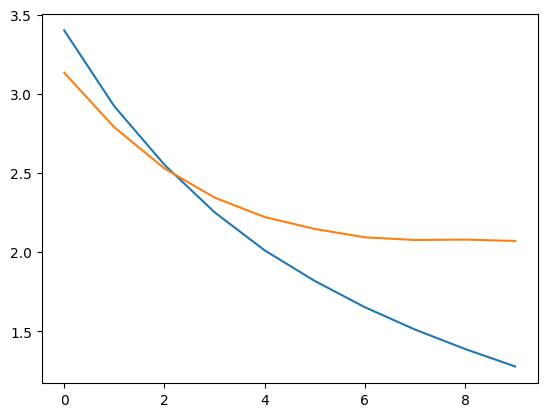

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.plot(train_losses)
plt.plot(val_losses)

In [91]:
import matplotlib.gridspec as gridspec

In [98]:
# Define the translation function
def translate_sentence(model, src_sentence,device, max_len=50):
    model.eval()
    with torch.no_grad():
        if isinstance(src_sentence, str):
            tokens = de_tokenizer(src_sentence)
        else:
            tokens = src_sentence


        tokens = ['<bos>'] + tokens + ['<eos>']
        src_indexes = de_vocab.lookup_indices(tokens)

        src_tensor = torch.tensor(src_indexes).unsqueeze(0).to(device)

        src_mask = model.make_src_mask(src_tensor)

        with torch.no_grad():
            enc_src = model.encoder(src_tensor,src_mask)



        BOS_INDEX = en_vocab.get_stoi()["<bos>"]

        trg_indexes = [BOS_INDEX]


        for i in range(max_len):

            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

            trg_mask = model.make_trg_mask(trg_tensor)
            with torch.no_grad():
                output, attention = model.decoder(trg_tensor, enc_src, trg_mask,src_mask)


            # pred_token = output.argmax(1)[:,-1].item()
            tokens = output.argmax(2)
            tokens = tokens.view(-1)
            pred_token = tokens[-1]
            trg_indexes.append(pred_token)

            if pred_token == en_vocab.get_stoi()["<eos>"]:
                break

    trg_tokens = en_vocab.lookup_tokens(trg_indexes)

    return trg_tokens[1:] , attention


def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):

    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(10,15))
    gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.4, hspace=0.4)
    for i in range(n_heads):

        # ax = fig.add_subplot(n_rows, n_cols, i+1)
        ax = fig.add_subplot(gs[i])
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],rotation = 70,fontsize = 10)
        ax.set_yticklabels(['']+translation,fontsize = 10)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()



In [84]:
def get_test_data(filepaths): #test_filepaths
    raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    return raw_de_iter,raw_en_iter

In [85]:
test_x,test_y = get_test_data(test_filepaths)
src_arr = []
trg_arr = []
for x,y in zip(test_x,test_y):
    src_arr.append(x)
    trg_arr.append(y)

src Eine Mutter und ihr kleiner Sohn genießen einen schönen Tag im Freien.

trg A mother and her young song enjoying a beautiful day outside.

predicted trg = ['A', 'mother', 'and', 'her', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '\n', '<eos>']


<ipython-input-98-5254c1164875>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],rotation = 70,fontsize = 10)
<ipython-input-98-5254c1164875>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation,fontsize = 10)


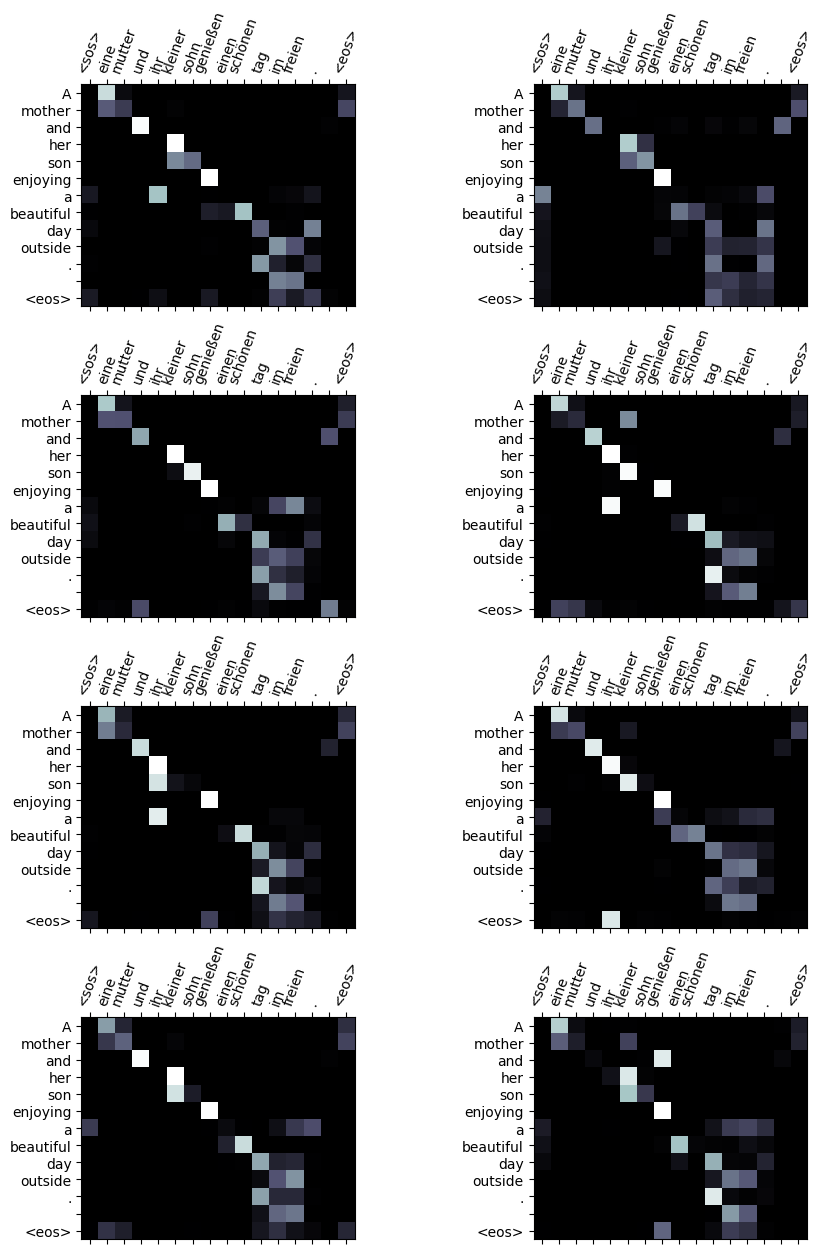

In [99]:
example_idx = 10
src = src_arr[example_idx]
trg = trg_arr[example_idx]
print('src',src)
print('trg',trg)
translation, attention = translate_sentence(model,src, device)

print(f'predicted trg = {translation}')

# display_attention(src, translation, attention)
src = de_tokenizer(src)
display_attention(src, translation, attention)


src Leute, die vor einem Gebäude stehen.

trg People standing outside of a building.

predicted trg = ['People', 'standing', 'in', 'front', 'of', 'a', 'building', '.', '\n', '<eos>']


<ipython-input-98-5254c1164875>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],rotation = 70,fontsize = 10)
<ipython-input-98-5254c1164875>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation,fontsize = 10)


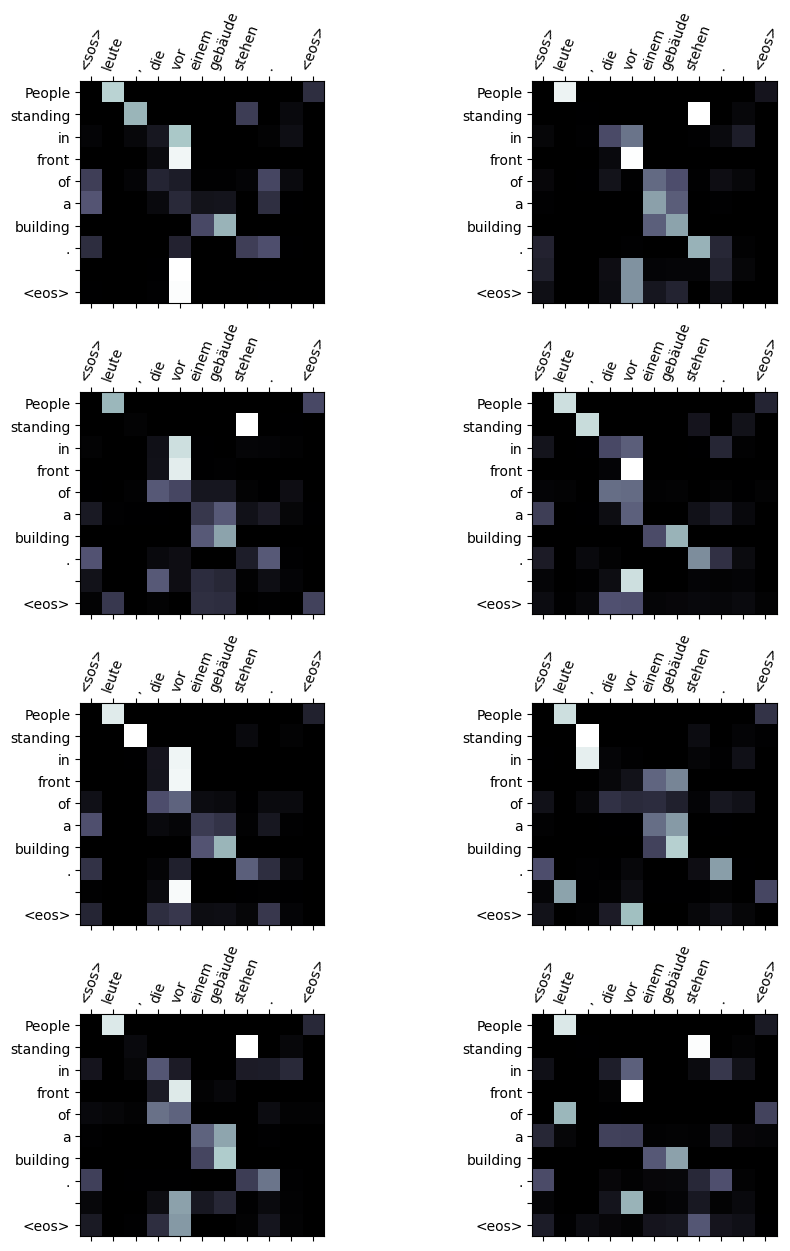

In [100]:
example_idx = 20
src = src_arr[example_idx]
trg = trg_arr[example_idx]
print('src',src)
print('trg',trg)
translation, attention = translate_sentence(model,src, device)

print(f'predicted trg = {translation}')

src = de_tokenizer(src)
display_attention(src, translation, attention)

src Die Person im gestreiften Shirt klettert auf einen Berg.

trg The person in the striped shirt is mountain climbing.

predicted trg = ['The', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'climbing', 'a', 'mountain', '.', '\n', '<eos>']


<ipython-input-98-5254c1164875>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],rotation = 70,fontsize = 10)
<ipython-input-98-5254c1164875>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation,fontsize = 10)


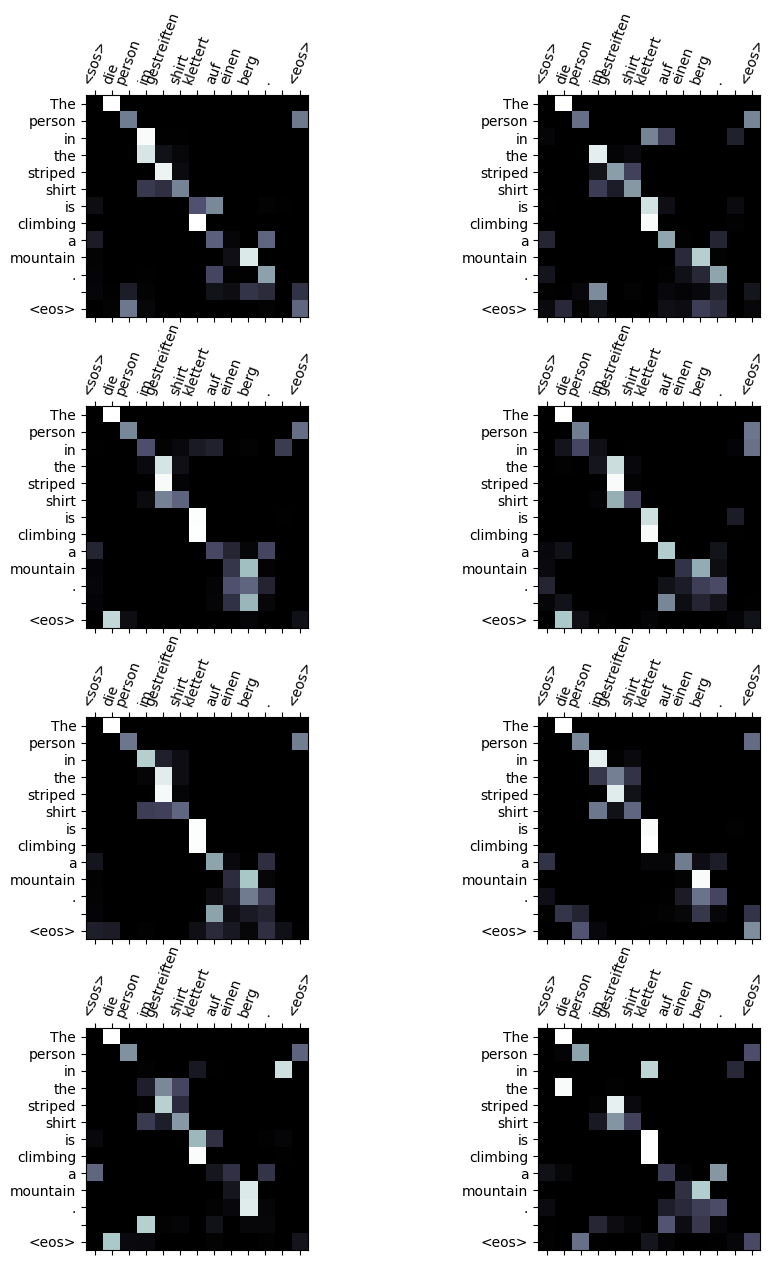

In [101]:
example_idx = 18
src = src_arr[example_idx]
trg = trg_arr[example_idx]
print('src',src)
print('trg',trg)
translation, attention = translate_sentence(model,src, device)

print(f'predicted trg = {translation}')

src = de_tokenizer(src)
display_attention(src, translation, attention)